# **LSTM & BiLSTM & GRU**

In [ ]:

!pip install konlpy -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import random  as rn
import tensorflow as tf

from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import time
import datetime


import warnings
warnings.filterwarnings('ignore')


## **1) 데이터 가져오기**  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

file_path = "/content/gdrive/My Drive/Colab Notebooks/wtm/finalproj/"


Mounted at /content/gdrive/


In [ ]:
# 데이터 불러오기
hunjea_cases = pd.read_csv(file_path + "분야별_헌재판례.csv")

#개수가 적은 6번 카테고리는 삭제
hunjea_cases = hunjea_cases[hunjea_cases.Category != '헌법위원회 및 대법원 헌법판례']

#헌법재판소에서 지정해둔 Category에 맞게 Num 부여
ca_list = hunjea_cases['Category'].unique()
y = []

for i in range( len(hunjea_cases) ) :
  tmp = hunjea_cases['Category'][i]
  num = 0
  for j in ca_list :
    if j == tmp :
      y.append(num)
    else :
      num += 1

#dataFrame으로 변환
df_y = pd.DataFrame({"CaNum" : y})

#최종 df
findf = hunjea_cases.drop('Category', axis=1)
findf = findf.drop('CaseNum', axis=1)
alldf = pd.concat([df_y, findf], axis=1)

### 데이터 split 및 정제

In [ ]:
train_data, test_data = train_test_split(alldf, test_size=0.2, random_state=1)

# 정규표현식 사용하여 데이터 정제
train_data['Content'] = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", sent) for sent in train_data.Content]
#공백 및 빈 값 제거
train_data['Content'] = [re.sub("^ +", "", sent) for sent in train_data.Content]
train_data['Content'].replace("", np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')


# test 데이터에 지금까지 진행했던 전처리 과정들을 동일하게 진행

test_data['Content'] = [re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", sent) for sent in test_data.Content]  # 정규 표현식 수행
test_data['Content'] = [re.sub("^ +", "", sent) for sent in test_data.Content]    # 공백은 empty 값으로 변경
test_data['Content'].replace("", np.nan, inplace=True)                             # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any')                        # Null 값 제거


### 토큰화

In [ ]:
# 불용어를 정의

stopwords = ['규정', '조항', '대한' ,'소원' ,'목적', '요지', '헌법소원심판', '필요', '사건', '위헌', '합헌', '법률', '제청', '청구인', '변호인', '제청', '재판', '피고인', '변호사', '심판', '청구' ,'재판관', '이유' ,'위헌확인', '피청구인', '수사' ,'이유', '원칙', '여부', '확인', '우리', '법률조항', '반대의견', '확인', '하나', '무엇', '제한', '인정', '대상', '입법', '헌법재판소', '재판소']
okt = Okt()

# train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장
X_train = []

start = time.time()    # 시작 시간 기록 ==============================

for sentence in train_data['Content']:
    temp_X = okt.nouns(sentence)     # 토큰화
    #CNN이니까 Topic Modeling이랑은 달리 nouns 아니고 그냥 형태소(morphs)로 하는 건가,,,,,,,,,
    temp_X = [word for word in temp_X if  (len(word) > 1) and (not word in stopwords)] # 불용어 제거
    X_train.append(temp_X)


processing_time = time.time() - start    # 경과 시간 계산  ==============================
times = str(datetime.timedelta(seconds = processing_time))
print()
print('▶ 수행 시간 = ', times)



▶ 수행 시간 =  0:02:24.511934


In [ ]:
# test 데이터에 대해서도 동일하게 토큰화를 진행
X_test = []

start = time.time()    # 시작 시간 기록 ==============================

for sentence in test_data['Content']:
    temp_X = okt.nouns(sentence) # 토큰화
    temp_X = [word for word in temp_X if  (len(word) > 1) and (not word in stopwords)] # 불용어 제거
    X_test.append(temp_X)

processing_time = time.time() - start    # 경과 시간 계산  ==============================
times = str(datetime.timedelta(seconds = processing_time))
print()
print('▶ 수행 시간 = ', times)


▶ 수행 시간 =  0:00:37.699009


In [ ]:
# 정수 인코딩
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

sorted_items = sorted(tokenizer.word_index.items(), key=lambda item: item[1], reverse=True)

# 새로운 단어 인덱스 생성 (빈도수가 높은 단어일수록 큰 숫자를 할당)
reversed_word_index = {word: idx for idx, (word, _) in enumerate(sorted_items, 1)}

# 새로운 단어 인덱스를 tokenizer에 할당
tokenizer.word_index = reversed_word_index

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['CaNum'])
y_test = np.array(test_data['CaNum'])

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


In [ ]:
# padding

max_len = 900

# 모든 샘플의 길이를 n으로 맞추어 줌

pad_X_train = pad_sequences(tok_X_train, maxlen = max_len)

pad_X_test = pad_sequences(tok_X_test, maxlen = max_len)

# n 미만인 애들은 padding해서 0으로 채워


## 데이터 확인

In [ ]:
print('◎ train 판례 : {}'.format(len(pad_X_train)))
print('◎ test 판례 : {}'.format(len(pad_X_test)))

◎ train 판례 : 509
◎ test 판례 : 126


In [ ]:
# 첫번째 X_train 판례를 출력
#
# 토큰화과 정수 인코딩(각 단어를 정수로 변환)이 끝난 상태

print('◎ 첫번째 train set 판례 :\n', pad_X_train[0])
print()

print('◎ 첫번째 train set 판례의 레이블 : ', y_train[0])


◎ 첫번째 train set 판례 :
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

In [ ]:
# 각 레이블에 대한 정확한 개수를 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)

print("◎ 각 레이블에 대한 빈도수:")

pd_data = pd.DataFrame(counts_elements, index=unique_elements, columns=["빈도"])

display(pd_data)


◎ 각 레이블에 대한 빈도수:


,빈도
0.0,2036
1.0,509


In [ ]:
# 각 단어와 그 단어에 부여된 인덱스를 리턴
print(tokenizer.word_index)

{'교호신문': 1, '주변인': 2, '날선': 3, '성품': 4, '복기': 5, '증거물': 6, '콘솔': 7, '저장매체': 8, '이동식': 9, '인멸하거': 10, '미진': 11, '연달': 12, '속단': 13, '불법선거': 14, '네트워킹': 15, '촌지': 16, '찬조': 17, '편람': 18, '요식업': 19, '수산물': 20, '자칫하면': 21, '졸속': 22, '일소': 23, '부조리': 24, '뜻함': 25, '배속': 26, '수행평가': 27, '경매': 28, '수상': 29, '항이므': 30, '변론기일': 31, '목도': 32, '취항': 33, '보안법': 34, '촉수': 35, '출국심사': 36, '퇴폐': 37, '심성': 38, '엔터프라이즈': 39, '서초': 40, '수건': 41, '직접강제': 42, '관상': 43, '탑재': 44, '승용자동차': 45, '이상일': 46, '입수': 47, '안기부': 48, '녹취록': 49, '홍석현': 50, '이학수': 51, '아무': 52, '전치': 53, '숙려': 54, '법의학': 55, '의대': 56, '유아윤': 57, '병술': 58, '정길': 59, '도박': 60, '관광객': 61, '연륜': 62, '뉴시스': 63, '오종택': 64, '김인철': 65, '행정감사': 66, '표목': 67, '반기': 68, '지방자치제': 69, '성차별': 70, '각개': 71, '제도보장': 72, '족문': 73, '도식': 74, '잔재': 75, '중기': 76, '다변': 77, '소생': 78, '복속': 79, '뿌리': 80, '화합': 81, '효친': 82, '숭조': 83, '고정관념': 84, '영속': 85, '대대로': 86, '부흥': 87, '분가': 88, '일조': 89, '경비계엄': 90, '포고': 91, '군사혁명': 92, '색출': 93, '제헌': 94, '반혁명': 

In [ ]:
for key, value in tokenizer.word_counts.items():   # 단어와 빈도수의 쌍(pair)을 key와 value로 받음
    print(f"{key} : {value}")

In [ ]:
# word_to_index에서 key와 value를 반대로 저장한 index_to_word를 만듦
# => 정수로부터 단어를 알 수 있도록 함


index_to_word = {}

for key, value in tokenizer.word_index.items():
    index_to_word[value] = key


In [ ]:
# 인덱스를 입력하여 단어를 확인 (1)

print('◎ 빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))


◎ 빈도수 상위 1번 단어 : 교호신문


In [ ]:
# 인덱스를 입력하여 단어를 확인 (2)

print('◎ 빈도수 상위 130번 단어 : {}'.format(index_to_word[200]))


◎ 빈도수 상위 130번 단어 : 방패


In [ ]:
# index_to_word에서 숫자 0은 패딩을 빈값으로 설정
#
# 이를 반영하여 index_to_word를 완성

index_to_word[0] = ''


# X_train[0] 내용 복원

text = ' '.join([index_to_word[index] for index in pad_X_train[0]])

text


'                                                                                                                                                                                                                                                                                                                                                                                                                     배경 민법 부동산 권리 등기 비로소 대하 효력 발생 대법원 부터 판례 로서 부동산 실질 권리자 자신 다른 사람 이름 등기 소위 명의신탁 등기 경우 외적 명의 탁자 권리자 대내 명의신탁 권리 보유 명의신탁 경우 투기 탈세 탈법 행위 수단 남용 국회 부동산 실권 리자 등기 제정 이르렀다 부동산 물권 변동 경우 명의신탁 약정 명의 탁자 명의 등기 실명 등기 의무 채무 변제 담보 채권자 부동산 물권 이전 경우 양도담보 채무자 채권 금액 채무 변제 담보 기재 서면 등기 신청서 기관 제출 또한 시행 실명 등기 의무 위반 명의신탁 시행일 로부터 유예 기간 이내 실명 등기 의무 이행 기존 명의신탁 부동산 실질 권리 취득 기준 일로 이내 소유권 이전 등기 신청 장기 등기 시행일 로부터 유예 기간 이내 서면 제출 의무 이행 기존 양도담보 대하 부동산 가액 해당 과징금 부과 시장 청장 과징금 부과 사람 부과 처분 취소소송 제기 법원 위헌법률심판 결정 주요 내용 다수 의견 인의 다수 의견 과징금 부과 대해 헌법불합치 선언 개정 효력 법원 기타 국가 기관 지방자치단체 개정 항의 적용 중지 결정 다음 명의신탁 과징금 부과 시행 후의 명의신탁 기존 명의신탁 유예 기간 실명 

## **2) LSTM**

In [ ]:
# 등장 빈도 순위 하위 7000개의 단어들만 사용

vocab_size = 8537 #내가 설정 (성능에 영향 미침)

# 길이를 900으로 패딩
max_len = 900 #내가 설정 (성능에 영향 미침)

In [ ]:
# 임베딩 벡터의 차원은 100
embedding_dim = 100

# 은닉 상태의 크기는 128
hidden_units = 128

# 5개의 분류 중 하나의 선택지를 예측하는 다중 클래스 분류 문제
num_classes = 5

# 모델 설정
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))    # 훈련 파라미터 : embedding_dim * 어휘수

model.add(LSTM(hidden_units, dropout=0.5))                      # 훈련 파라미터 : 4(n*m+n*n+n)  /* n : hidden_units 크기 , m : embedding_dim */

# 다중 클래스 분류 : 소프트맥스 함수를 사용
model.add(Dense(num_classes, activation='softmax'))  # 훈련 파라미터 : (num_classes * hidden_units) + num_classes

model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         853700    
                                                                 
 lstm_12 (LSTM)              (None, 128)               117248    
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 971593 (3.71 MB)
Trainable params: 971593 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title 🌐 Call Back 함수 설정

# (1) 검증 데이터 손실(val_loss)이 증가~~하면, 과적합 징후이므로 검증 데이터 손실이 4회 이내 개선되지 않으면 학습을 조기 종료(Early Stopping) ~~
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# (2) 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 ~~~~~좋아질 경우에만 (최고일 경우에만)~~~ 모델을 저장

mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Keras 사용시 최대한 reproducible results 를 얻기 위해 아래 코드 실행 (단, 완벽하지는 않음)
#
# 매번 정확하게 동일한 결과를 얻기 위해서는 (1) GPU 대신 CPU 를 사용하고, (2) Mulithread 를 사용하지 않도록 조정 해야함
#

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers

# 손실 함수로 크로스 엔트로피 함수를 사용
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


%time history = model.fit(pad_X_train, y_train, batch_size=64, epochs=50, callbacks=[es, mc], validation_data=(pad_X_test, y_test))
#%time history = model.fit(pad_X_train, y_train, batch_size=64, epochs=50, validation_data=(pad_X_test, y_test)) #callback 없는 버전


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.6064 - acc: 0.2633
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_LSTM.h5
8/8 [==============================] - 23s 3s/step - loss: 1.6064 - acc: 0.2633 - val_loss: 1.6054 - val_acc: 0.2143
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.5819 - acc: 0.2633
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 18s 2s/step - loss: 1.5819 - acc: 0.2633 - val_loss: 1.6102 - val_acc: 0.2143
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.6350 - acc: 0.3183
Epoch 3: val_acc improved from 0.21429 to 0.32540, saving model to best_model_LSTM.h5
8/8 [==============================] - 18s 2s/step - loss: 1.6350 - acc: 0.3183 - val_loss: 1.5864 - val_acc: 0.3254
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.5239 - acc: 0.4283
Epoch 4: val_acc did not improve from 0.32540
8/8 [==============================] - 1

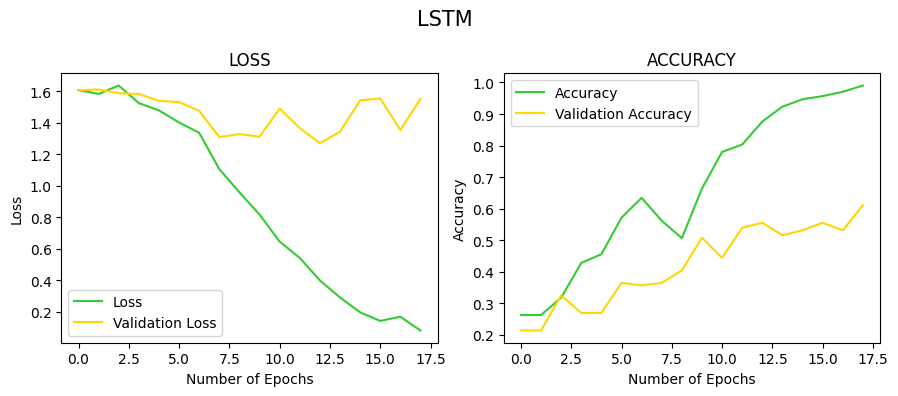

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="limegreen", label = "Loss")
plt.plot(history.history['val_loss'], color="gold", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="limegreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="gold", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("LSTM", fontsize=15)
fig.tight_layout() # 사용하면 플롯간 여백을 조정

plt.show()

In [ ]:
# 저장된 모델인 'best_model.h5'를 로드하고, 성능을 평가

loaded_model = load_model('best_model_LSTM.h5')


# loaded_model.evaluate 출력값 : loss & acc 값이 출력됨
#
# loss 값 출력시 [0]으로 호출
# acc 값 출력시 [1]으로 호출

# acc = loaded_model.evaluate(X_test, y_test)[1]

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n◎ 테스트 정확도: %.4f" % (acc[1]))


4/4 [==============================] - 3s 354ms/step - loss: 1.5504 - acc: 0.6111
[1.5504484176635742, 0.6111111044883728]


◎ 테스트 정확도: 0.6111


### confusion matrix

4/4 [==============================] - 4s 873ms/step


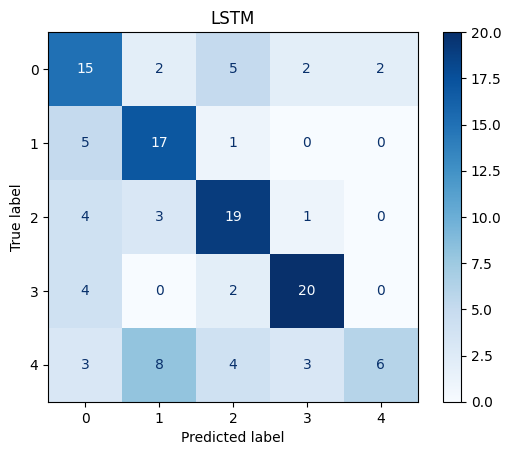

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM")
plt.show()

## **3) BiLSTM**

In [ ]:
# 등장 빈도 순위 상위 n개의 단어들만 사용
vocab_size = 8537

# 모든 길이를 900으로 패딩
max_len = 900

In [ ]:
# 임베딩 벡터의 차원은 100
embedding_dim = 100

# 은닉 상태의 크기는 128
hidden_units = 128

# 5개의 분류 중 하나의 선택지를 예측하는 다중 클래스 분류 문제
num_classes = 5


# 모델 설정
model_bi = Sequential()

model_bi.add(Embedding(vocab_size, embedding_dim))

model_bi.add(Bidirectional(LSTM(hidden_units, dropout=0.5)))        # >>>Bidirectional LSTM<<을 사용  👈👈👈

model_bi.add(Dense(num_classes, activation='softmax')) # 다중 클래스 분류 문제의 경우, 소프트맥스 함수를 사용


model_bi.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         853700    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 1089481 (4.16 MB)
Trainable params: 1089481 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title 🌐 Call Back 함수 설정
#
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 이내 개선되지 않으면 학습을 조기 종료(Early Stopping)
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

mc = ModelCheckpoint('best_model_biLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# random seed 설정

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers

# 손실 함수로 크로스 엔트로피 함수를 사용
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

%time history = model_bi.fit(pad_X_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(pad_X_test, y_test))


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.6028 - acc: 0.2534
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_biLSTM.h5
8/8 [==============================] - 44s 5s/step - loss: 1.6028 - acc: 0.2534 - val_loss: 1.6162 - val_acc: 0.2143
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.5861 - acc: 0.2593
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 35s 5s/step - loss: 1.5861 - acc: 0.2593 - val_loss: 1.6141 - val_acc: 0.2143
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.5311 - acc: 0.3045
Epoch 3: val_acc improved from 0.21429 to 0.33333, saving model to best_model_biLSTM.h5
8/8 [==============================] - 38s 5s/step - loss: 1.5311 - acc: 0.3045 - val_loss: 1.6611 - val_acc: 0.3333
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 1.4179 - acc: 0.4578
Epoch 4: val_acc did not improve from 0.33333
8/8 [==============================]

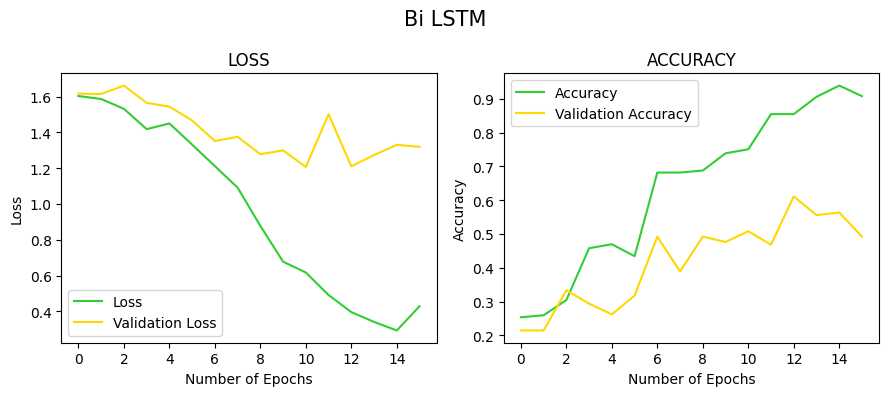

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="limegreen", label = "Loss")
plt.plot(history.history['val_loss'], color="gold", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="limegreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="gold", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("Bi LSTM", fontsize=15)
fig.tight_layout() # 사용하면 플롯간 여백을 조정

plt.show()

In [ ]:
# 저장된 모델인 'best_model_biLSTM.h5'를 로드하고, 성능을 평가

loaded_model = load_model('best_model_biLSTM.h5')

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n◎ 테스트 정확도: %.4f" % (acc[1]))


4/4 [==============================] - 5s 641ms/step - loss: 1.2103 - acc: 0.6111
[1.2102848291397095, 0.6111111044883728]


◎ 테스트 정확도: 0.6111


### confusion matrix

4/4 [==============================] - 6s 1s/step


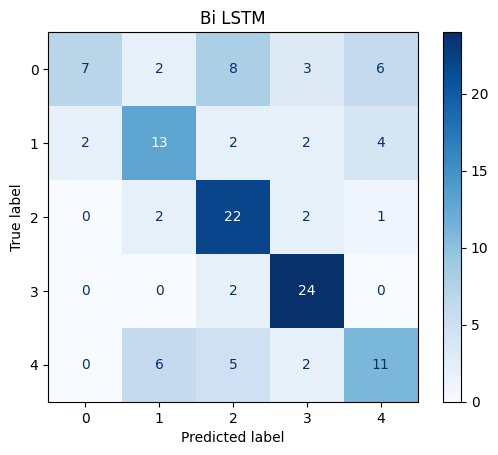

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Bi LSTM")
plt.show()

## **4) GRU**

In [ ]:
# 임베딩 벡터의 차원은 100
embedding_dim = 100

# 은닉 상태의 크기는 128
hidden_units = 128

# 5개의 분류 중 하나의 선택지를 예측하는 다중 클래스 분류 문제
num_classes = 5

# 모델 설정

model_bi = Sequential()

model_bi.add(Embedding(vocab_size, embedding_dim))

model_bi.add(GRU(hidden_units, dropout=0.5))        # GRU 사용  👈👈👈

model_bi.add(Dense(num_classes, activation='softmax')) # 다중 클래스 분류 문제의 경우, 소프트맥스 함수를 사용


model_bi.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         853700    
                                                                 
 gru_3 (GRU)                 (None, 128)               88320     
                                                                 
 dense_14 (Dense)            (None, 5)                 645       
                                                                 
Total params: 942665 (3.60 MB)
Trainable params: 942665 (3.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title 🌐 Call Back 함수 설정
#
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 이내 개선되지 않으면 학습을 조기 종료(Early Stopping)
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

mc = ModelCheckpoint('best_model_GRU.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# random seed 설정

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers


# 손실 함수로 크로스 엔트로피 함수를 사용
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


# epoch는 총 30번을 수행, (epoch 당 1~2초 소요)
# batch_size는 64로 설정
# 또한 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인

%time history = model_bi.fit(pad_X_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(pad_X_test, y_test))


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.6057 - acc: 0.2083
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_GRU.h5
8/8 [==============================] - 22s 2s/step - loss: 1.6057 - acc: 0.2083 - val_loss: 1.6061 - val_acc: 0.2143
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.5861 - acc: 0.2593
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 16s 2s/step - loss: 1.5861 - acc: 0.2593 - val_loss: 1.6102 - val_acc: 0.2143
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.5678 - acc: 0.2554
Epoch 3: val_acc did not improve from 0.21429
8/8 [==============================] - 16s 2s/step - loss: 1.5678 - acc: 0.2554 - val_loss: 1.6153 - val_acc: 0.2143
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 1.5300 - acc: 0.2574
Epoch 4: val_acc did not improve from 0.21429
8/8 [==============================] - 17s 2s/step - loss: 1.5300 - acc: 0.2574 -

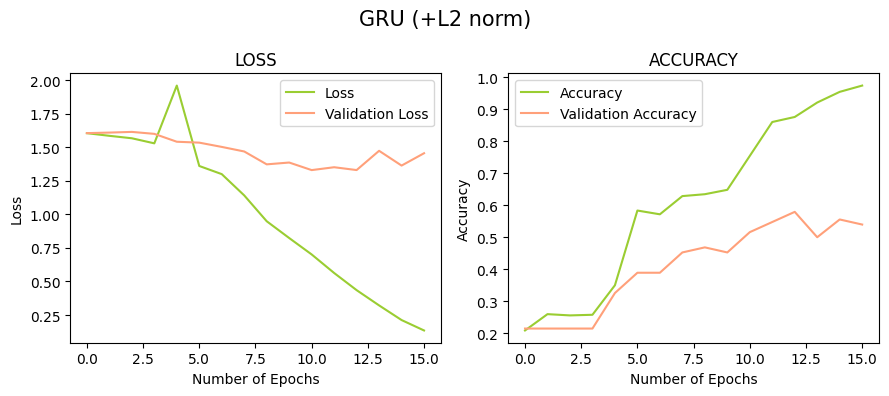

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="yellowgreen", label = "Loss")
plt.plot(history.history['val_loss'], color="lightsalmon", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="yellowgreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="lightsalmon", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("GRU (+L2 norm)", fontsize=15)
fig.tight_layout() # 사용하면 플롯간 여백을 조정

plt.show()

In [ ]:
# 저장된 모델인 'best_model_GRU.h5'를 로드하고, 성능을 평가

loaded_model = load_model('best_model_GRU.h5')

# acc = loaded_model.evaluate(X_test, y_test)[1]

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n◎ 테스트 정확도: %.4f" % (acc[1]))
print(type(acc))


4/4 [==============================] - 3s 716ms/step - loss: 1.3308 - acc: 0.5794
[1.3307968378067017, 0.579365074634552]


◎ 테스트 정확도: 0.5794
<class 'list'>


### confusion matrix

4/4 [==============================] - 1s 209ms/step


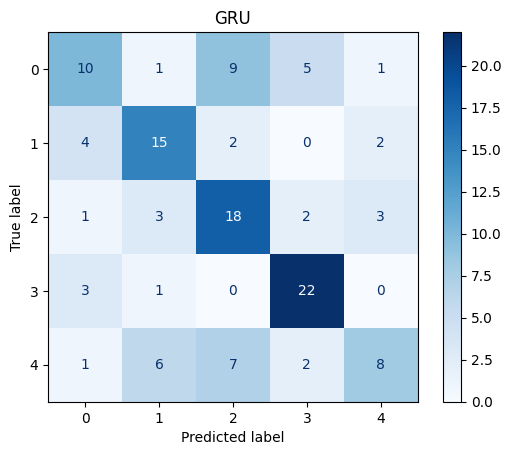

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("GRU")
plt.show()

In [ ]:
loaded_model = load_model('best_model_GRU.h5')
acc3 = loaded_model.evaluate(pad_X_test, y_test)

loaded_model = load_model('best_model_LSTM.h5')
acc1 = loaded_model.evaluate(pad_X_test, y_test)

loaded_model = load_model('best_model_biLSTM.h5')
acc2 = loaded_model.evaluate(pad_X_test, y_test)


4/4 [==============================] - 6s 985ms/step - loss: 1.2103 - acc: 0.6111


In [ ]:
data = [acc4, acc1, acc2, acc3]

# 데이터프레임 생성
df = pd.DataFrame(data, columns=['loss', 'accuracy'], index=['CNN', 'LSTM', 'bi LSTM', 'GRU'])
df

,loss,accuracy
LSTM,1.550448,0.611111
bi LSTM,1.210285,0.611111
GRU,1.330797,0.579365
